# 1. Imports and Denpendency

In [1]:
#import numpy for number array handling and represent rgb image pixel values
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import libraries for visualization of data
import matplotlib.pyplot as plt

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline

from PIL import Image
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model


In [2]:
print(tf.version.VERSION)

2.9.1


# 2. Download and Unzip

In [2]:
# download dataset from drive
!gdown --id 1yNQSeduHFQi21a5TvexQTKRzofYuizJM

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1yNQSeduHFQi21a5TvexQTKRzofYuizJM
To: /content/waste-dataset-resized-fix.zip
100% 29.6M/29.6M [00:00<00:00, 230MB/s]


In [5]:
# unzip the dataset
import zipfile
with zipfile.ZipFile("D:\Kuliah\Bangkit\SAMPAHKU\waste-classification-fix\dataset\waste-dataset-resized-fix.zip","r") as zip_ref:
    zip_ref.extractall("waste-dataset")

# 3. Load and Split images then applying Data Preprocessing and Data Augmentation

In [3]:
#paths to the train, validation and test image datasets 
train_path = r'waste-dataset\waste-dataset-resized-fix\training'
valid_path = r'waste-dataset\waste-dataset-resized-fix\training'


# extract images to training set by applying data preprocessing and data augmentation
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1).flow_from_directory(
    directory=train_path, target_size=(224,224), classes=['cardboard', 'compost', 'glass', 'metal', 
                                                         'paper', 'plastic'], batch_size=16, subset='training')


# extract images to validation set
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['cardboard', 'compost', 'glass', 'metal', 
                                                         'paper', 'plastic'], batch_size=16, subset='validation')


Found 2312 images belonging to 6 classes.
Found 255 images belonging to 6 classes.


# 4. Visualization of the images after Preprocessing

In [4]:
# plot images after applying VGG16 data preprocessing method
def plotImages(images):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

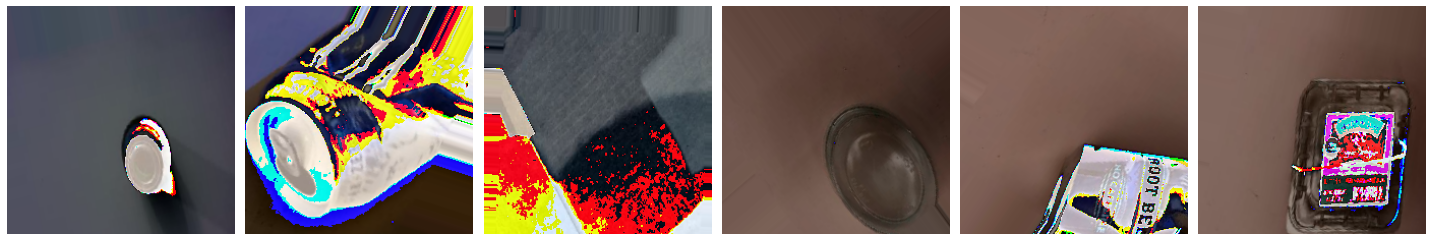

In [5]:
imgs, labels = next(train_batches)
plotImages(imgs)

# 5. Create callback to stop training when accuracy and validation reach the goal

In [6]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    # Check accuracy
    # Stop the training when reaching 90% accuracy and 80% validation accuracy
    if(logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.8):

      # Stop if threshold is met
      print("\nGood enough accuracy and validation!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

# 6. Building the CNN Architecture

In [8]:
# set the input image size for proposed CNN model
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE, 
                                        include_top=False,
                                        weights='imagenet')

In [16]:
# summary of convolution base of VGG16 model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

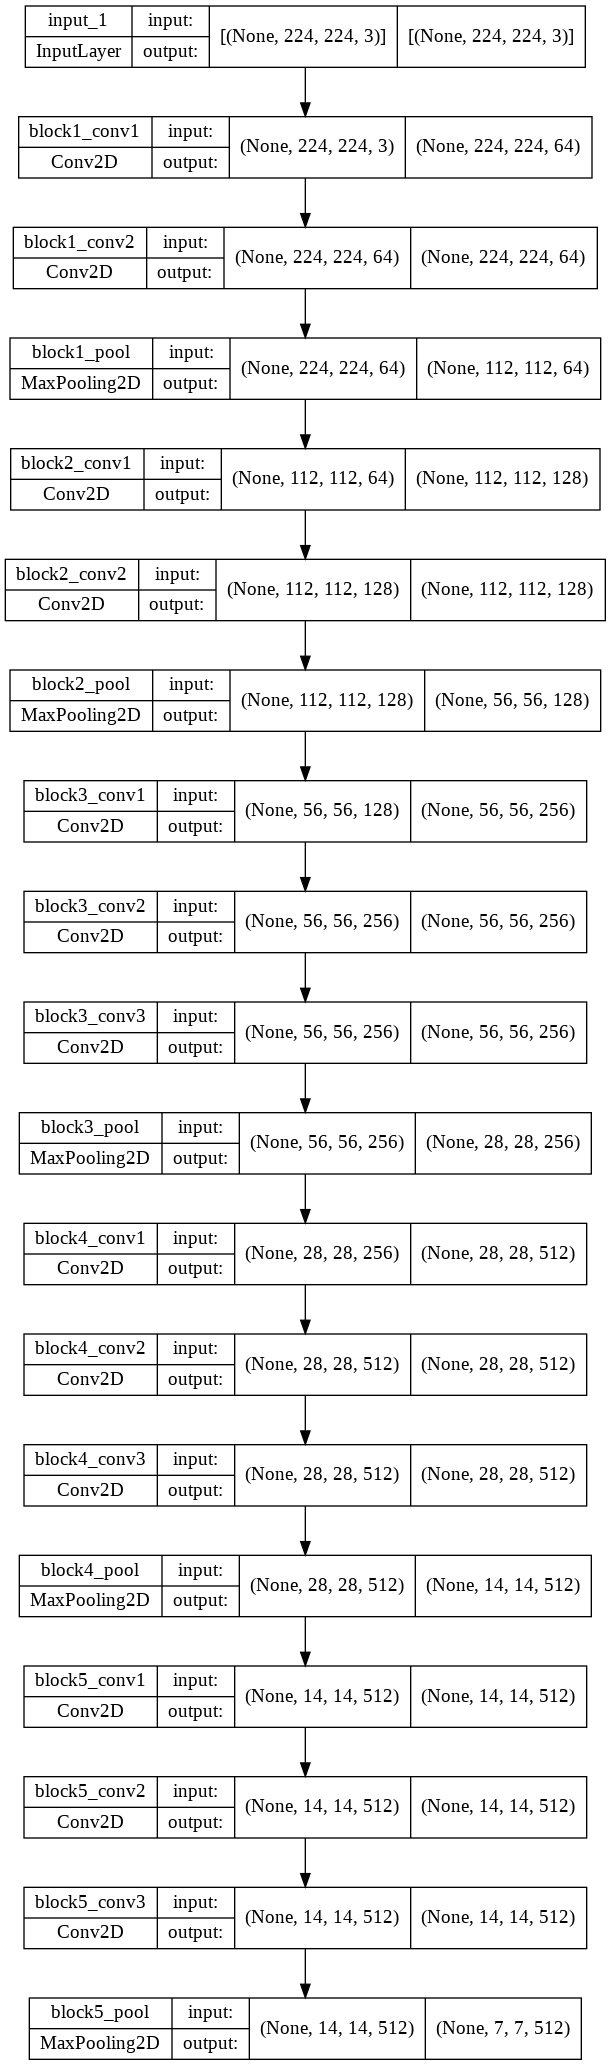

In [10]:
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
# Initialize a sequential model
model = Sequential()

# Freeze the convolutional base layer 
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(Dropout(0.2))                         # applies dopout to randomly disable 20% of hidden units

model.add(Flatten())

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(Dropout(0.2))                        # applies dopout to randomly disable 20% of hidden units

model.add(Dense(units=6, activation='softmax')) # use Softmax function to do predictions with 6 classes

In [10]:
# summary of proposed CNN model(architecture)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

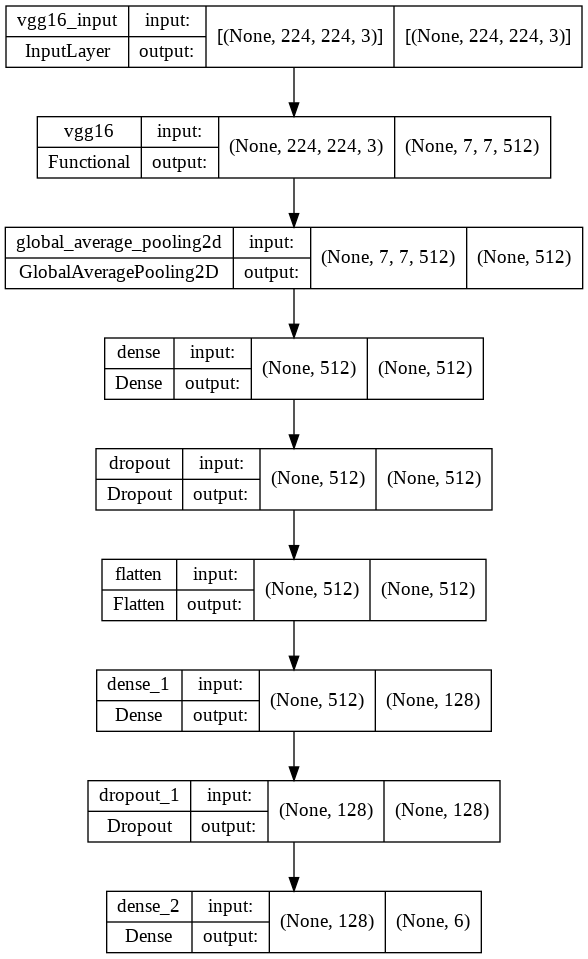

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# 7. Compile the Built CNN Model

In [11]:
# compile the built CNN model by selecting suitable optimizer and loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 8. Train the CNN model

In [12]:
# train the model with appropriate number of epochs
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2, callbacks=[callbacks])

Epoch 1/30
145/145 - 527s - loss: 1.7205 - accuracy: 0.4511 - val_loss: 0.9246 - val_accuracy: 0.6902 - 527s/epoch - 4s/step
Epoch 2/30
145/145 - 531s - loss: 0.9450 - accuracy: 0.6644 - val_loss: 0.7702 - val_accuracy: 0.7137 - 531s/epoch - 4s/step
Epoch 3/30
145/145 - 501s - loss: 0.7658 - accuracy: 0.7314 - val_loss: 0.5923 - val_accuracy: 0.7765 - 501s/epoch - 3s/step
Epoch 4/30
145/145 - 504s - loss: 0.6479 - accuracy: 0.7660 - val_loss: 0.6191 - val_accuracy: 0.7608 - 504s/epoch - 3s/step
Epoch 5/30
145/145 - 527s - loss: 0.5841 - accuracy: 0.7889 - val_loss: 0.5504 - val_accuracy: 0.8196 - 527s/epoch - 4s/step
Epoch 6/30
145/145 - 524s - loss: 0.5434 - accuracy: 0.8080 - val_loss: 0.5397 - val_accuracy: 0.8314 - 524s/epoch - 4s/step
Epoch 7/30
145/145 - 535s - loss: 0.4827 - accuracy: 0.8261 - val_loss: 0.4814 - val_accuracy: 0.8471 - 535s/epoch - 4s/step
Epoch 8/30
145/145 - 526s - loss: 0.4648 - accuracy: 0.8413 - val_loss: 0.4755 - val_accuracy: 0.8431 - 526s/epoch - 4s/step


In [13]:
# store the losses of training
loss = model_details.history['loss']
validation_loss = model_details.history['val_loss']

In [14]:
# store the accuracy of training
accuracy = model_details.history['accuracy']
validation_accuracy = model_details.history['val_accuracy']

# 9. Fine Tune the CNN model

In [15]:
# unfreeze the convolution base of VGG16 
base_model.trainable=True

In [16]:
# summary of the fine-tune CNN model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                        

In [17]:
# train and fine-tune the model with appropriate number of epochs
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2, callbacks=[callbacks])

Epoch 1/10

Good enough accuracy and validation!
145/145 - 492s - loss: 0.2686 - accuracy: 0.9053 - val_loss: 0.3848 - val_accuracy: 0.8627 - 492s/epoch - 3s/step


# 10. Visulization of Accuracy and Loss in Training and  Validation sets

In [18]:
# append the losses to previous stored losses
loss.extend(model_details.history['loss'])
validation_loss.extend(model_details.history['val_loss'])

In [19]:
# append the accuracy to previous stored accuracy
accuracy.extend(model_details.history['accuracy'])
validation_accuracy.extend(model_details.history['val_accuracy'])

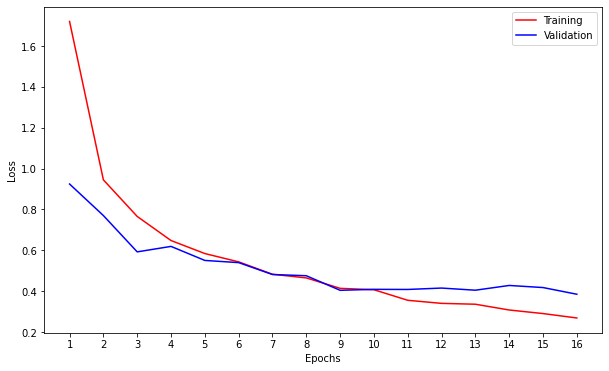

In [20]:
# plot the training and validation losses
epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

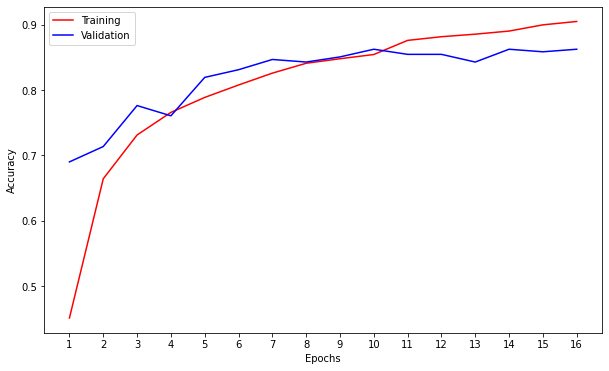

In [21]:
# plot the training and validation accuracy
epochs = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs,accuracy,c="red",label="Training")
plt.plot(epochs,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()

# 11. Show Prediction

In [39]:
test_image = image.load_img('/content/waste-dataset-resized-fix/test/glass90.jpg',
                            target_size = (224, 224))

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)

[[1.0351890e-06 1.0108348e-06 9.9498874e-01 1.2224118e-04 1.9236616e-07
  4.8867445e-03]]


In [40]:
train_batches.class_indices

{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5}

In [41]:
classes=['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic']

prediction = result
#return position of max
MaxPosition=np.argmax(prediction)  
prediction_label=classes[MaxPosition]
print(prediction_label) 

glass


# 12. Export The Model


In [29]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path)